# Wheel turning speed time series analysis

**THESE ARE ROUGH NOTES - NEED IMPROVING**

In the experiment, the response of the animal is recorded through the turning speed of a steering wheel. 

This notebook is a guide for how to analyse this data.

* Section 1 - loading the datafile and converting data to easily workable format

* Section 2 - visualising data at various levels (individual trials and all trials together)

* Section 3 - determining a response from the wheel speed data (turning direction)

* Section 4 - validating results against Steinmetz et al. 

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## 1) Loading dataset

**Libraries Used:**

- **xarray:** 
  - `xr.load_dataset()`: Loads a dataset from a specified file path using the xarray library. It facilitates data manipulation and analysis of multi-dimensional arrays.
  - `to_dataframe()`: Converts the loaded xarray dataset into a Pandas DataFrame for easier data manipulation and analysis.
 
- **Pandas:**
    - `df.reset_index()`: reset the index of a dataframe.
    - `df.groupby('grouping_variable')`: split a dataframe into chunks according to a `grouping_variable`
    - `df.DataFrame({'col1':col1_values, 'col2':col2_values}`: create a dataframe from a dictionary of data columns

In [6]:
dataset = xr.load_dataset('/home/ben/ibots/workshop_data/steinmetz_mouse/convert_steinmetz_dataset/data/processed/neuropixels/steinmetz_2016-12-14_Cori.nc')
dataset

<xarray.Dataset>
Dimensions:         (mouse: 1, session_date: 1, trial: 364, time: 250, cell: 734)
Coordinates:
  * mouse           (mouse) object 'Cori'
  * session_date    (session_date) object '2016-12-14'
  * trial           (trial) int64 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364
  * time            (time) float64 0.01 0.02 0.03 0.04 ... 2.47 2.48 2.49 2.5
  * cell            (cell) int64 1 2 3 4 5 6 7 8 ... 728 729 730 731 732 733 734
Data variables: (12/24)
    contrast_left   (mouse, session_date, trial) int8 100 0 100 0 ... 0 25 100
    contrast_right  (mouse, session_date, trial) int8 0 50 50 0 ... 25 50 0 100
    gocue           (mouse, session_date, trial) float64 1.027 0.8744 ... nan
    stim_onset      (mouse, session_date, trial) float64 0.5 0.5 0.5 ... 0.5 0.5
    feedback_type   (mouse, session_date, trial) float64 1.0 1.0 1.0 ... nan nan
    feedback_time   (mouse, session_date, trial) float64 1.187 1.438 ... nan nan
    ...              ...
    spks            (mouse, session_date, cell, trial, time) int8 0 0 0 ... 0 0
    trough_to_peak  (mouse, session_date, cell) int8 19 19 10 17 ... 16 8 20 10
    ccf_ap          (mouse, session_date, cell) float64 4.09e+03 ... 8.914e+03
    ccf_dv          (mouse, session_date, cell) float64 2.445e+03 ... 4.094e+03
    ccf_lr          (mouse, session_date, cell) float64 5.012e+03 ... 3.021e+03
    brain_area      (mouse, session_date, cell) object 'ACA' 'MOs' ... 'DG'
Attributes:
    bin_size:    0.01
    stim_onset:  0.5

In [192]:
# drop nans from dataframe!
# THIS SHOULD BE DONE IN DATA PREPROCESSING! NOT AN EXERCISE FOR THE STUDENTS
dataset = dataset.where(dataset.active_trials==1 , drop=True)

**Exercises**

Convert the wheel speed data into a Pandas DataFrame 

In [193]:
wheel_data = dataset['wheel'].to_dataframe()

wheel_data

wheel
mouse session_date trial time       
Cori  2016-12-14   1     0.01   -1.0
                         0.02    0.0
                         0.03    0.0
                         0.04    0.0
                         0.05    0.0
...                              ...
                   214   2.46    3.0
                         2.47    2.0
                         2.48    2.0
                         2.49    3.0
                         2.50    2.0

[53500 rows x 1 columns]

Add a column to the dataframe that gives a unique identifier for every datapoint

In [194]:
wheel_data['data_id'] = range(0, len(wheel_data))

wheel_data

wheel  data_id
mouse session_date trial time                
Cori  2016-12-14   1     0.01   -1.0        0
                         0.02    0.0        1
                         0.03    0.0        2
                         0.04    0.0        3
                         0.05    0.0        4
...                              ...      ...
                   214   2.46    3.0    53495
                         2.47    2.0    53496
                         2.48    2.0    53497
                         2.49    3.0    53498
                         2.50    2.0    53499

[53500 rows x 2 columns]

Reset the index of the DataFrame and name the result `df`

In [195]:
df = wheel_data.reset_index()

df

,mouse,session_date,trial,time,wheel,data_id
0,Cori,2016-12-14,1,0.01,-1.0,0
1,Cori,2016-12-14,1,0.02,0.0,1
2,Cori,2016-12-14,1,0.03,0.0,2
3,Cori,2016-12-14,1,0.04,0.0,3
4,Cori,2016-12-14,1,0.05,0.0,4
...,...,...,...,...,...,...
53495,Cori,2016-12-14,214,2.46,3.0,53495
53496,Cori,2016-12-14,214,2.47,2.0,53496
53497,Cori,2016-12-14,214,2.48,2.0,53497
53498,Cori,2016-12-14,214,2.49,3.0,53498


Notice how the structure of the DataFrame changed!

### Manipulate data into a convenient format

The above dataframe contains datapoints for all trials on a given session date. This is not the most convenient format, as it does not allow for easy separation of trials. 

A better format is a dataframe with each column representing a trial and the rows representing the time bin.

Make a list of arrays of wheel speed for each trial and a list of trial numbers.

In [196]:
wheel_list = [group.wheel.values for group_name, group in wheel_data.groupby("trial")]
trial_list = [group_name for group_name, group in wheel_data.groupby("trial")]

Use these arrays to produce a dataframe where each column represents a trial an the time bins are given by the index.

Call this dataframe `wheel_df`

In [197]:
wheel_df = pd.DataFrame({trial_list[i]: wheel_list[i] for i in range(len(trial_list))})
wheel_df.index.name = 'time_bin'
wheel_df

,1,2,3,4,5,6,7,8,9,10,...,205,206,207,208,209,210,211,212,213,214
time_bin,,,,,,,,,,,,,,,,,,,,,
0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.0,0.0,0.0,0.0,-7.0,1.0,0.0,0.0,0.0,0.0,...,0.0,5.0,-1.0,0.0,-1.0,3.0,2.0,0.0,0.0,3.0
246,0.0,0.0,0.0,0.0,-6.0,2.0,0.0,0.0,1.0,1.0,...,0.0,4.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0
247,1.0,1.0,-1.0,0.0,-6.0,2.0,0.0,0.0,0.0,0.0,...,0.0,5.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0


## 2) Data visualisation

**Libraries Used:**
- **Pandas:**
    - `df['time']`: accessing individual columns
- **matplotlib:**
  - `plt.plot()`: Plot data on the current axes.
  - `plt.xlabel()`: Set the x-axis label for the current axes.
  - `plt.ylabel()`: Set the y-axis label for the current axes.
  - `plt.legend()`: Show the legend labels for the current axes.

**Exercises**

Select the wheel speed data from a single trial

In [198]:
selected_data = wheel_df[5]
selected_data

time_bin
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
245   -7.0
246   -6.0
247   -6.0
248   -4.0
249   -3.0
Name: 5, Length: 250, dtype: float32

Plot the wheel speed against time for the single selected trial

Text(0, 0.5, 'wheel speed/arb. units')

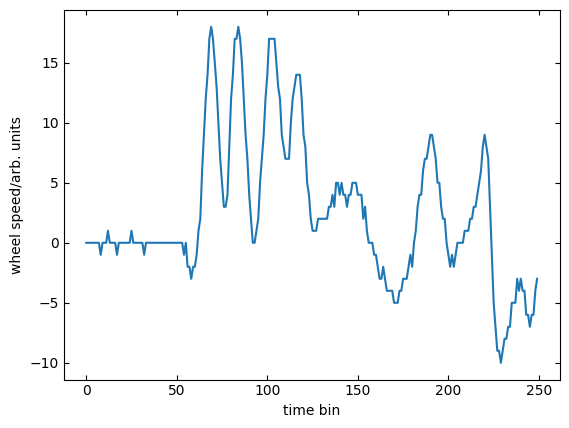

In [199]:
plt.plot(selected_data)
plt.xlabel('time bin')
plt.ylabel('wheel speed/arb. units')

Plot wheel speed against time for multiple trials

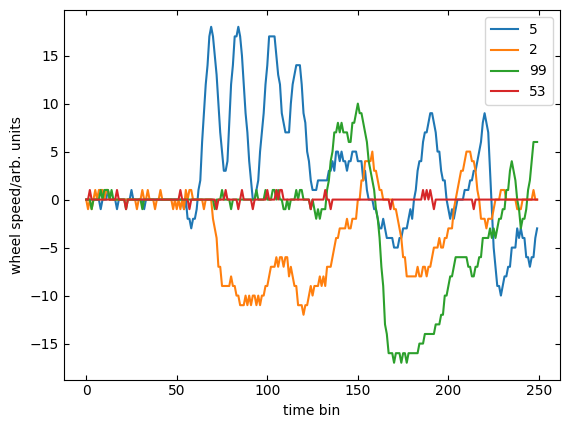

In [200]:
wanted_trials = [5,2,99,53]
selected_data = wheel_df[wanted_trials]

plt.plot(selected_data, label=wanted_trials)
plt.xlabel('time bin')
plt.ylabel('wheel speed/arb. units')
plt.legend()

Make a plot that shows the wheel speeds for all trials 

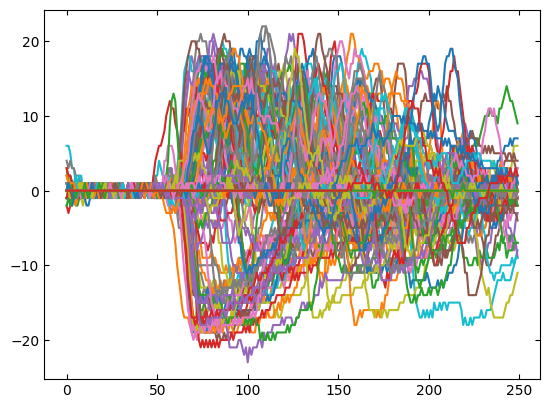

In [201]:
plt.plot(wheel_df);

Looks overplotted! Let's do better (possible homework exercise!!)

We can make a plot, known as a heatmap, where each pixel tells us how many datapoints occupy that region. This allows us to plot a large number of trials at once, while still being able to see the contributions of individual trials.


Look at the range and type of values that the wheel speed data and time bin data have. We will use this information to define bins in the x and y directions. 

In [228]:
# range of wheel speed data - many ways to do this!
print(wheel_df.values.min(), wheel_df.values.max())

# look at unique values of wheel speed
print(np.unique(wheel_df))

# look at unique values of time index
print(np.unique(wheel_df.index))

-23.0 22.0
[-23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.
  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.
   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.
  19.  20.  21.  22.]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185

Now define reasonable bins in the x and y directions for the heatmap

In [ ]:
x_bins = wheel_df.index.values
y_bins = np.arange(wheel_df.min(axis=None), wheel_df.max(axis=None),1)


From the bins, set up an empty matrix that will store the values for the heatmap. Call this matrix `heatmap_matrix`

In [ ]:
heatmap_matrix = np.zeros([ len(y_bins[:-1]),len(x_bins[:-1])])

The `histogram2d` function from `numpy` counts the number of points lying in the specified bins when given the x and y values of the points.

Use this function on one colum of the dataframe `wheel_df`. Store the resulting matrix in a variable called `h`

In [236]:
h,xx,yy = np.histogram2d(wheel_df[1],wheel_df.index.values, bins=[ y_bins,x_bins])

Visualise `h` with matplotlib's `imshow` function

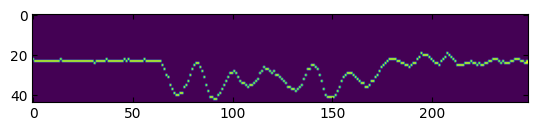

In [237]:
plt.imshow(h)

Now do the same for every column of `wheel_df`, summing the result to `heatmap_matrix`

In [238]:
for i, col in wheel_df.items():
    h,xx,yy = np.histogram2d(col,wheel_df.index.values, bins=[ y_bins,x_bins])
    heatmap_matrix += h


Visualise `heatmap_matrix`. Hint- you may find it useful to use a logarithmic colourscale. Investigate the `norm` argument of `imshow` for this.

Text(0, 0.5, 'wheel speed/arb. units')

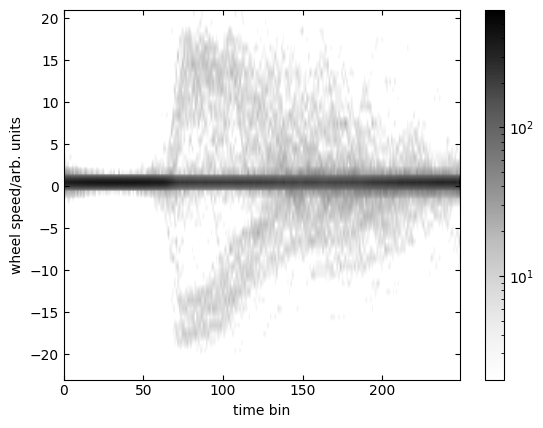

In [239]:
im = plt.imshow(heatmap_matrix, 
                norm=LogNorm(), 
                cmap=plt.cm.Greys,
                interpolation='bilinear',
                aspect='auto',
                origin="lower",
                extent=[min(x_bins),max(x_bins),min(y_bins),max(y_bins)] )
plt.colorbar(im)

plt.xlabel("time bin")
plt.ylabel("wheel speed/arb. units")

### All together in one cell 

Text(0, 0.5, 'wheel speed/arb. units')

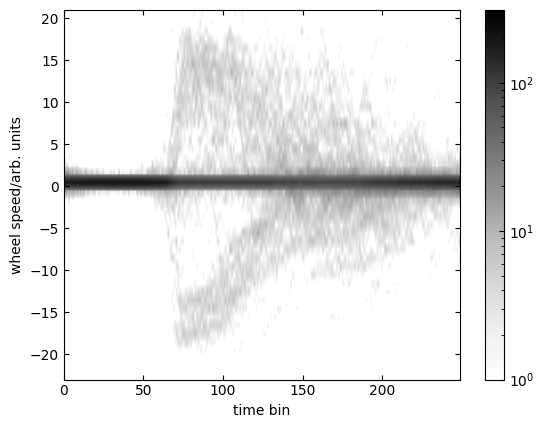

In [202]:
y_bins = np.arange(wheel_df.min(axis=None), wheel_df.max(axis=None),1)
x_bins= wheel_df.index.values

heatmap_matrix = np.zeros([ len(y_bins[:-1]),len(x_bins[:-1])])

for i, col in wheel_df.items():
    h,xx,yy = np.histogram2d(col,wheel_df.index.values, bins=[ y_bins,x_bins])
    heatmap_matrix += h

im = plt.imshow(heatmap_matrix, 
                norm=LogNorm(), 
                cmap=plt.cm.Greys,
                interpolation='bilinear',
                aspect='auto',
                origin="lower",
                extent=[min(x_bins),max(x_bins),min(y_bins),max(y_bins)] )
plt.colorbar(im)

plt.xlabel("time bin")
plt.ylabel("wheel speed/arb. units")

## 3) Determining Turning Direction

**Libraries Used:**


- **Pandas:**
    - `df.mean()`: reset the index of a dataframe.
    - `df[df['col1'] >10]`: index filtering based on a condition

**Exercises**

Make a dataframe containing the mean wheel speed for each trial

In [203]:
mean_wheel_speeds = wheel_df.mean()

mean_df = pd.DataFrame({'mean_speed':mean_wheel_speeds, 'trial': mean_wheel_speeds.index})

mean_df

,mean_speed,trial
1,4.376,1
2,-2.944,2
3,2.616,3
4,-0.268,4
5,2.532,5
...,...,...
210,1.268,210
211,2.364,211
212,-0.004,212
213,-0.008,213


Use `mean_df` and `wheel_df` to make a plot of wheel speeds where the mean speed was greater than 0

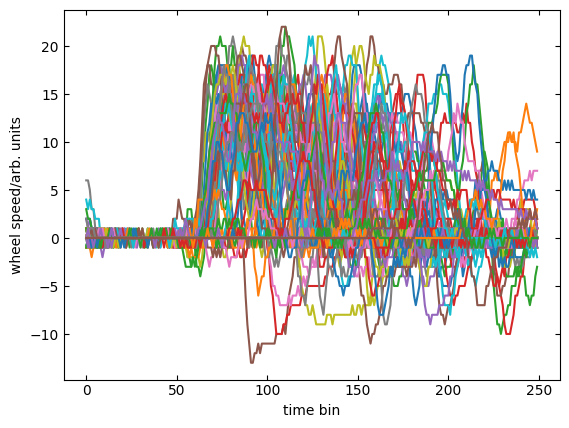

In [204]:
selected_trials = mean_df[mean_df['mean_speed'] > 0]

selected_data = wheel_df[selected_trials['trial']]

plt.plot(selected_data)
plt.xlabel('time bin')
plt.ylabel('wheel speed/arb. units')
plt.show()

## 4 Result Validation

**Libraries Used:**

- **Python:**
    - `print()`: print information to the console 

- **Pandas:**
    - `df['col'].isin(values)`: find rows of dataframe where datapoints are contained in a list of values
 
- **matplotlib:**
    - `plt.scatter()`: make a scatter plot
    - `plt.scatter(color='some color', marker='some marker')`: change marker properties of scatter plot

Get response types from Steinmetz data

In [205]:
response_df = dataset.response_type.to_dataframe()
response_df.reset_index(inplace=True)

Find trials where `response_type` is 1 (that means wheel was turned to the right, ie. with a positive speed)

In [206]:
steinmetz_trials = response_df[response_df.response_type==1]['trial']

Find trials where mean speed was positive and response recorded by Steinmetz was 1


In [207]:
trials_with_positive_mean_speed_and_response_1 = mean_df[(mean_df['mean_speed'] > 0) & (mean_df['trial'].isin(steinmetz_trials))]

Assess quantitatively the agreement between the recorded responses in the dataset and the response obtained from the mean speed

In [208]:
print('number of trials with response_type==1: ', len(steinmetz_trials))
print('number of trials with positive mean speed: ', len(mean_df[(mean_df['mean_speed'] > 0) ]))
print('number of trials with positive mean speed and response_type==1: ', len(trials_with_positive_mean_speed_and_response_1))

number of trials with response_type==1:  71
number of trials with positive mean speed:  116
number of trials with positive mean speed and response_type==1:  67


Make a scatter plot of trial number against mean wheel speed for trials with positive mean speed

Text(0, 0.5, 'mean wheel speed')

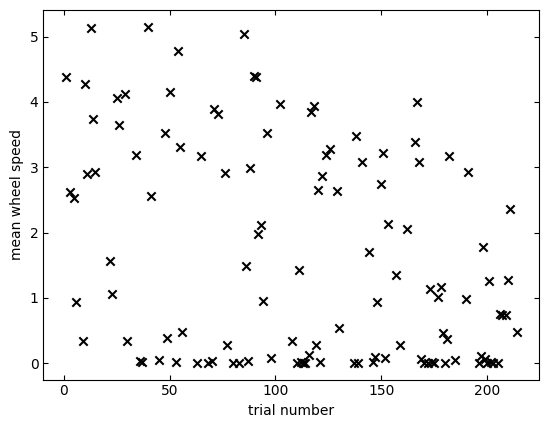

In [209]:
plt.scatter(mean_df[mean_df['mean_speed'] > 0]['trial'] ,mean_df[mean_df['mean_speed'] > 0]['mean_speed'], color='k', marker='x')

plt.xlabel('trial number')
plt.ylabel('mean wheel speed')

Include on the same plot the trials where mean wheel speed is positive and the response recorded by Steinmetz is 1. 

Use a different marker types to distinguish between the data

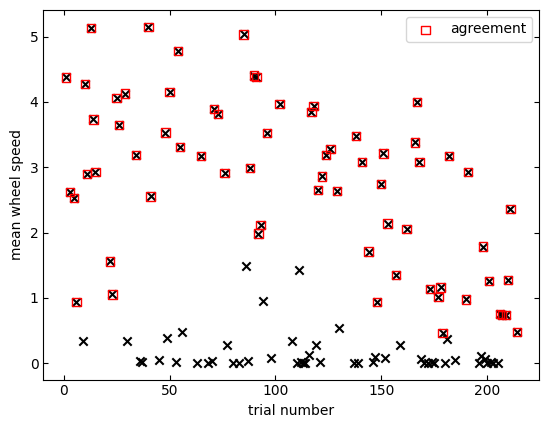

In [210]:
plt.scatter(mean_df[mean_df['mean_speed'] > 0]['trial'] ,mean_df[mean_df['mean_speed'] > 0]['mean_speed'], color='k', marker='x')

plt.scatter(trials_with_positive_mean_speed_and_response_1['trial'], 
            trials_with_positive_mean_speed_and_response_1['mean_speed'], 
            marker='s',
            color='r',
            facecolor='none', label='agreement')


plt.xlabel('trial number')
plt.ylabel('mean wheel speed')
plt.legend()